In [63]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy 
from tabulate import tabulate
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score

In [2]:
DATA_DIR = "data/"
STOCKFISH_DIR = 'stockfish/'
ARCHIVE_DIR = DATA_DIR + 'archives/'
BITBOARD_DIR = DATA_DIR + 'bitboards/'
ELITE_DATA_BASE_URL  = "https://database.nikonoel.fr/"
STOCKFISH_DOWNSTREAM = "https://github.com/official-stockfish/Stockfish/releases/latest/download/"

SAMPLE_ZIP = "lichess_elite_2021-11.zip"
SAMPLE_PGN = "lichess_elite_2021-11.pgn"
SAMPLE_BITBOARD = "elite_bitboard.csv"
BITBOARD_1M = "1M.csv"
BITBOARD_10M = "10M.csv"
ELITE_DATA_SAMPLE_URL = ELITE_DATA_BASE_URL + SAMPLE_ZIP
SAMPLE_ZIP_FILE = ARCHIVE_DIR + SAMPLE_ZIP
SAMPLE_PGN_FILE  = DATA_DIR + SAMPLE_PGN

STOCKFISH_AVX512_TAR = "stockfish-ubuntu-x86-64-avx512.tar"
STOCKFISH_AVX512 = "stockfish-ubuntu-x86-64-avx512"
STOCKFISH_AVX512_URL = STOCKFISH_DOWNSTREAM + STOCKFISH_AVX512_TAR
STOCKFISH_AVX512_EXE = STOCKFISH_DIR + STOCKFISH_AVX512

SAMPLE_BITBOARD_FILE = BITBOARD_DIR + SAMPLE_BITBOARD
BITBOARD_10M_FILE = BITBOARD_DIR + BITBOARD_10M
BITBOARD_1M_FILE = BITBOARD_DIR + BITBOARD_1M

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
class BitboardDrawDataset(Dataset):
    def __init__(self, bitboard_file):
        bitboards_df = pd.read_csv(bitboard_file, sep=";", dtype="uint64", usecols=range(12))
        metadata_df = pd.read_csv(bitboard_file, sep=";", dtype="int64", usecols=['draw'])

        self.bitboards = np.unpackbits(np.ascontiguousarray(bitboards_df.to_numpy()).view(np.uint8), axis=1).astype(np.single)
        self.is_draw = metadata_df['draw'].to_numpy(dtype=np.single)
        self.length = self.is_draw.size

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.bitboards[idx], self.is_draw[idx]

In [56]:
class SimpleModel(nn.Module):

    def __init__(self, neurons=256):
        super().__init__()
        self.neurons = neurons
        self.model = nn.Sequential(
            nn.Linear(768, neurons),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(neurons, 1)
        )

    def forward(self, x):
        return self.model.forward(x)

In [64]:
def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f"Took: {te-ts:.2f}s")
        return result
    return timed

class Train:
    
    def __init__(self, train_file, validate_file):
        self.train_dataset, self.validate_dataset = BitboardDrawDataset(train_file), BitboardDrawDataset(validate_file)
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=32, shuffle=True, pin_memory=True, pin_memory_device=device.type)
        self.validate_train_dataloader = DataLoader(self.train_dataset, batch_size=len(self.train_dataset), shuffle=True, pin_memory=True, pin_memory_device=device.type)
        self.validate_test_dataloader = DataLoader(self.validate_dataset, batch_size=len(self.validate_dataset), shuffle=True, pin_memory=True, pin_memory_device=device.type)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.total_batches = len(self.train_dataloader)
        self.print_every = 100
        self.epoch_print_interval = 1
        
    def train_one_epoch(self, model, optimizer, p=False) -> int:
        running_loss = 0.
        last_loss = 0.
    
        for i, data in enumerate(self.train_dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.unsqueeze(1).to(device)
    
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            if i % self.print_every == self.print_every - 1:
                last_loss = running_loss / self.print_every
                if p: print(f"  batch {i+1} loss: {last_loss}")
                running_loss = 0.
            elif i == self.total_batches - 1:
                last_loss = running_loss / (i % self.print_every + 1)
                if p: print(f"  batch {i+1} loss: {last_loss}")
            
        return last_loss
    
    @timeit
    def train(self, model, optimizer, epochs, p=True):
        best_vloss = np.inf
        best_model = deepcopy(model.state_dict())
        best_epoch = 0
        best_acc = 0
    
        for epoch in range(1, epochs + 1):
            if p and epoch % self.epoch_print_interval == 0 or epoch == 1: print(f'EPOCH {epoch}')
        
            # Make sure gradient tracking is on, and do a pass over the data
            model.train(True)
            avg_loss = self.train_one_epoch(model, optimizer)
        
            model.eval()
        
            with torch.no_grad():
                acc_train, acc_test = 0, 0
                loss_train, loss_test = 0, 0
                prec_train, prec_test = 0, 0
    
                for i, vdata in enumerate(self.validate_test_dataloader):
                    vinputs, vlabels = vdata
                    vinputs, vlabels = vinputs.to(device), vlabels.unsqueeze(1).to(device)
                    voutputs = model(vinputs)
                    pred = nn.functional.sigmoid(voutputs).round()
                    acc_test = (pred == vlabels).sum()
                    loss_test = self.loss_fn(voutputs, vlabels)
                    prec_test = precision_score(vlabels.to('cpu'), pred.to('cpu'))
                    
                for i, vdata in enumerate(self.validate_train_dataloader):
                    vinputs, vlabels = vdata
                    vinputs, vlabels = vinputs.to(device), vlabels.unsqueeze(1).to(device)
                    voutputs = model(vinputs)
                    pred = nn.functional.sigmoid(voutputs).round()
                    acc_train = (pred == vlabels).sum()
                    loss_train = self.loss_fn(voutputs, vlabels)
                    prec_train = precision_score(vlabels.to('cpu'), pred.to('cpu'))
                    
            acc_train = (acc_train / len(self.train_dataset)) * 100
            acc_test = (acc_test / len(self.validate_dataset)) * 100
            
            if p and epoch % self.epoch_print_interval == 0 or epoch == 1: 
                print(tabulate([["Loss", loss_train, loss_test], ["Precision", prec_train, prec_test], ["Accuracy", f"{acc_train:.2f}%", f"{acc_test:.2f}%"]],
                               headers=["", "Train", "Test"]))
        
            if loss_test < best_vloss:
                best_vloss = loss_test
                best_model = deepcopy(model.state_dict())
                best_epoch = epoch
                best_acc = acc_test
                
        return best_model, best_epoch, best_acc
    
                
    def save_model(self, state_dict, neurons, epoch, lr, momentum, acc):
        model_path = f"models/1M/model_{neurons}_{epoch}_{lr}_{momentum}_{acc:.2f}"
        torch.save(state_dict, model_path)
        
    
    def find_best_neuron(self, neurons, epochs, lr=1e-3, momentum=0.9):
        for n in neurons:
            print(f"Model {n}")
            model = SimpleModel(n)
            model.to(device)
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            best_model, epoch, acc = self.train(model, optimizer, epochs)
            self.save_model(best_model, n, epoch, lr, momentum, acc)
            print("")
        

In [65]:
pipe = Train("data/bitboards/100k_0-1441.csv", "data/bitboards/10k_144100-144237.csv")

In [66]:
pipe.find_best_neuron([64], 20)

Model 64
EPOCH 1
           Train               Test
---------  ------------------  ------------------
Loss       0.6050282120704651  0.585800290107727
Precision  0.6474086197490453  0.6944186046511628
Accuracy   69.07%              71.58%
EPOCH 2
           Train               Test
---------  ------------------  ------------------
Loss       0.5949164628982544  0.5806962847709656
Precision  0.6332768201940284  0.6848409748038001
Accuracy   69.33%              72.17%
EPOCH 3
           Train               Test
---------  ------------------  ------------------
Loss       0.5873903036117554  0.5789374113082886
Precision  0.6504616920389319  0.6909797151488994
Accuracy   69.70%              72.07%
EPOCH 4
           Train               Test
---------  ------------------  ------------------
Loss       0.5806217193603516  0.5788106322288513
Precision  0.6533384534152546  0.6842762063227953
Accuracy   70.06%              72.08%
EPOCH 5
           Train               Test
---------  ---------

In [32]:
validate_dataset = BitboardDrawDataset("data/bitboards/100k_0-1441.csv")
validate_dataloader = DataLoader(validate_dataset, batch_size=len(validate_dataset))

model = SimpleModel(128)
model.load_state_dict(torch.load("models/100K/sgd/model_128_5_0.1_0.9_66.86", map_location=device))
model.to(device)
model.eval()
with torch.no_grad():
    acc = 0
    vdata = next(iter(validate_dataloader))
    vinputs, vlabels = vdata
    vinputs, vlabels = vinputs.to(device), vlabels.unsqueeze(1).to(device)
    voutputs = model(vinputs)
    
    logits = nn.functional.sigmoid(voutputs)
    loss = nn.functional.binary_cross_entropy_with_logits(voutputs, vlabels).numpy()

    pred = logits > 0.5
    print(f"Acc: {(((pred == vlabels).sum() / len(validate_dataset)) * 100):.2f}%")
    print(f"Loss: {loss}")
    cm = confusion_matrix(vdata[1].to('cpu'), pred.to('cpu'))
    ConfusionMatrixDisplay(cm).plot(cmap='Oranges')


FileNotFoundError: [Errno 2] No such file or directory: 'models/100K/sgd/model_128_5_0.1_0.9_66.86'

In [26]:
arr = [(logits > k).cpu().numpy() for k in np.linspace(0, 1, 1000)]
acc_arr = [((i == vlabels.cpu().numpy()).sum() / 1000) for i in arr]
print(max(acc_arr))
acc_arr.index(max(acc_arr))

6.84


610

In [27]:
tparr = []
for i in arr:
    tparr.append(precision_score(vdata[1].to('cpu'), i))

/home/jan/venv/nn-snake/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best value: 0.72
Cutoff: 0.918


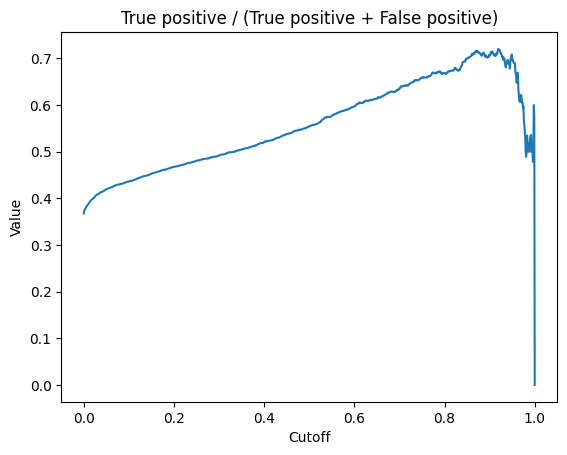

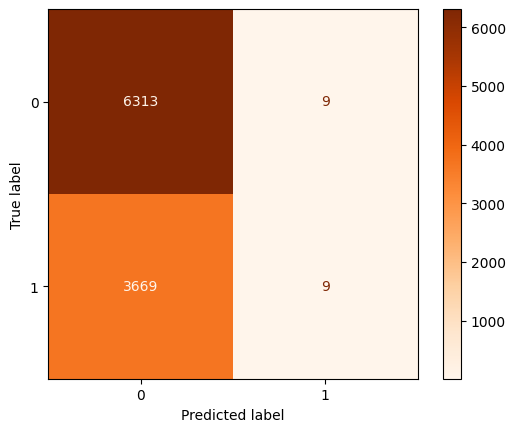

In [28]:
pred = logits > 0.997
plt.plot(np.linspace(0, 1, 1000), tparr)
plt.title("True positive / (True positive + False positive)")
plt.xlabel("Cutoff")
plt.ylabel("Value")
print(f"Best value: {max(tparr):.2f}\nCutoff: {tparr.index(max(tparr)) / 1000}")
cm = confusion_matrix(vdata[1].to('cpu'), pred.to('cpu'))
ConfusionMatrixDisplay(cm).plot(cmap='Oranges')

Best cutoff value: 0.61
Accuraccy : 68.40%


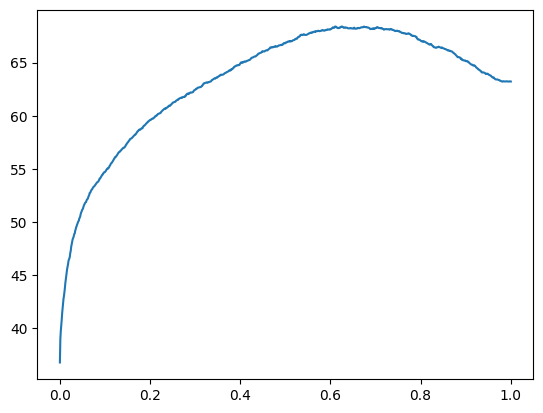

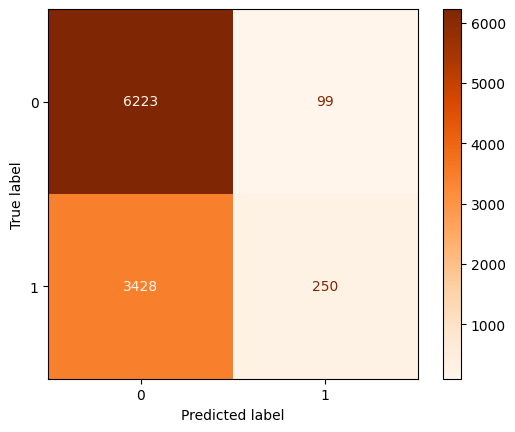

In [213]:
pred = logits > 0.918
plt.plot(np.linspace(0, 1, 1000), acc_arr)
print(f"Best cutoff value: {acc_arr.index(max(acc_arr)) / 1000}")
print(f"Accuraccy : {max(acc_arr):.2f}%")
cm = confusion_matrix(vdata[1].to('cpu'), pred.to('cpu'))
ConfusionMatrixDisplay(cm).plot(cmap='Oranges')

In [29]:
def unpack_to_bits(dataset):
    dataset.map(lambda x: ";".join(np.char.mod('%d', np.unpackbits(np.array([x]).view(np.uint8))))).to_csv("dataset_bits.csv", sep=";", index=False)
    bity = pd.read_csv("dataset_bits.csv", dtype="uint64", sep=";", header=None)
    dataset.rename(columns={"draw": 768})
    pd.concat([bity, dataset.rename(columns={"draw": 768})], axis=1).to_csv("dataset_bits.csv", sep=";", index=False)